In [1]:
import numpy as np
import matplotlib.pyplot as plt
from data import *
from minibatch import *

%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Get data from dataset5

In [2]:
dataset = get_dataset()

train_data, train_label_onehot, validation_data, validation_label_onehot, test_data, test_label_onehot \
    = split_train_validation_test(dataset)
    
X_validation, y_validation = get_data(validation_data, validation_label_onehot)

Total number of images in dataset5:  65774
Train data size:  61540
Train label size:  62540
Validation data size:  1000
Validation label size:  1000
Test data size:  3234
Test label size:  3234


## One Layer Model

In [13]:
from minibatch import *

import tensorflow as tf

D = 43200 #120*120*3

X = tf.placeholder(tf.float32, [None, WIDTH, HEIGHT, 3])
W = tf.Variable(tf.zeros([D, C]))
b = tf.Variable(tf.zeros([C]))

#regularization
gamma = 0.01

regularizer = tf.nn.l2_loss(W)

# model
logits = tf.matmul(tf.reshape(X, [-1, D]), W) + b

# placeholder for correct labels
Y_ = tf.placeholder(tf.float32, [None, C])

# loss function
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = Y_))
total_loss = cross_entropy + gamma*regularizer

# % of correct answers found in batch
is_correct = tf.equal(tf.argmax(logits,1), tf.argmax(Y_,1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

optimizer = tf.train.AdamOptimizer(learning_rate = 0.003,  beta1=0.9, beta2=0.999)
train_step = optimizer.minimize(total_loss)

# Saver
saver = tf.train.Saver()

In [14]:
BATCH_SIZE = 128
NUMBER_BATCH = int(len(train_data)/BATCH_SIZE)
EPOCHS = 2

print("number of batch = ", NUMBER_BATCH)

train_losses = []
train_accuracies = []
validation_accuracies = []

#Initialisation
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for _ in range(EPOCHS):
        for i in range(NUMBER_BATCH):
            # load batch of images and correct answers

            batch_X, batch_Y = get_batch(train_data, train_label_onehot, batch_number=i)
            batch_data = {X: batch_X, Y_: batch_Y}

            # train
            sess.run(train_step, feed_dict=batch_data)

            if i > 0 and i % 50 == 0:
                train_a, loss = sess.run([accuracy, total_loss], feed_dict=batch_data)
                train_losses.append(loss)
                train_accuracies.append(train_a)

                valid_a = sess.run(accuracy, feed_dict={X: X_validation, Y_: y_validation})
                validation_accuracies.append(valid_a)

                print(i, ":", " train loss = ", loss, "; train accuracy = ", train_a, "; validation accuracy = ", valid_a)

                # Save the variables to disk.
    save_path = saver.save(sess, "./tmp/one_layer/model_1layer_adam.ckpt")
    print("Model saved in file: %s" % save_path)

number of batch =  480
50 :  train loss =  830.989 ; train accuracy =  0.585938 ; validation accuracy =  0.514
100 :  train loss =  674.453 ; train accuracy =  0.578125 ; validation accuracy =  0.558
150 :  train loss =  538.356 ; train accuracy =  0.65625 ; validation accuracy =  0.567
200 :  train loss =  567.149 ; train accuracy =  0.648438 ; validation accuracy =  0.629
250 :  train loss =  620.048 ; train accuracy =  0.695312 ; validation accuracy =  0.638
300 :  train loss =  622.852 ; train accuracy =  0.65625 ; validation accuracy =  0.655
350 :  train loss =  353.291 ; train accuracy =  0.796875 ; validation accuracy =  0.643
400 :  train loss =  574.698 ; train accuracy =  0.703125 ; validation accuracy =  0.642
450 :  train loss =  423.544 ; train accuracy =  0.84375 ; validation accuracy =  0.701
50 :  train loss =  574.599 ; train accuracy =  0.71875 ; validation accuracy =  0.689
100 :  train loss =  348.975 ; train accuracy =  0.804688 ; validation accuracy =  0.701
150 

## Result on Test

In [16]:
def test_accuracy(model_path):
    with tf.Session() as sess:
        # Restore variables from disk.
        saver.restore(sess, model_path)
        print("Model restored.")
        N = len(test_data)    
        batch_size = 128
        batch_number = int(N/batch_size) + 1
        sum_correct = 0.
        for i in range(batch_number):
            batch_X, batch_Y = get_batch(test_data, test_label_onehot, i)
            n = batch_X.shape[0]
            a = sess.run(accuracy, feed_dict={X: batch_X, Y_: batch_Y})
            sum_correct += a*n
        
        test_accuracy = sum_correct/N
        print("final test accuracy = ", test_accuracy)
        
test_accuracy("./tmp/one_layer/model_1layer_adam.ckpt")

INFO:tensorflow:Restoring parameters from ./tmp/one_layer/model_1layer_adam.ckpt
Model restored.
final test accuracy =  0.707792207866


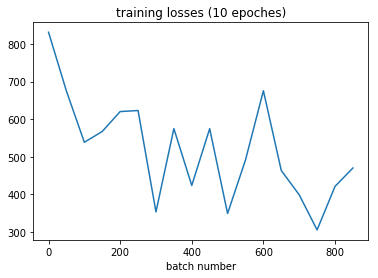

In [15]:
plt.plot(np.arange(len(train_losses))*50,train_losses)
plt.title("training losses (10 epoches)")
plt.xlabel("batch number")

In [89]:
import pandas as pd

In [90]:
results = pd.DataFrame({ 
    "losses":losses, 
    "train_accuracies":train_accuracies,
    "validation_accuracies":validation_accuracies
    })
results.to_csv("./results/one_layer_1_adam.csv")